In [204]:
import os
import pandas as pd
import numpy as np
import h5py
import os

def load_and_merge_sensor_data(recording_id, data_dir='data/tonmoy_phase1'):
    """
    Load and merge accelerometer and gyroscope data for a recording.
    
    Args:
        recording_id (str): Recording ID (e.g., 'recording0').
        data_dir (str): Base directory for data.
    
    Returns:
        pd.DataFrame: Merged DataFrame with timestamp, accel_x/y/z, gyro_x/y/z.
    """

    # Load CSV files
    accel_path = os.path.join(data_dir, recording_id, 'acceleration.csv')
    gyro_path = os.path.join(data_dir, recording_id, 'gyroscope.csv')
    
    accel = pd.read_csv(accel_path, skiprows=1)
    gyro = pd.read_csv(gyro_path, skiprows=1)
    
    # Calculate sampling rate (in Hz)
    sample_interval = accel['timestamp'].diff().median() * 1e-9  # Convert ns to seconds
    sample_rate = 1 / sample_interval
    print(f"Recording {recording_id}: Sample rate = {sample_rate:.2f} Hz")
    
    # Merge on timestamp
    accel = accel.rename(columns={'x': 'accel_x', 'y': 'accel_y', 'z': 'accel_z'})
    gyro = gyro.rename(columns={'x': 'gyro_x', 'y': 'gyro_y', 'z': 'gyro_z'})
    df = pd.merge_asof(
        accel.sort_values('timestamp'),
        gyro.sort_values('timestamp'),
        on='timestamp',
        tolerance=int(1e9 / sample_rate),  # 1/sample_rate in ns
        direction='nearest'
    )
    df = df.dropna()  # Drop rows with missing values
    return df, sample_rate

In [ ]:
import datetime

Recording 2024-01-31_13_13_13: Sample rate = 99.01 Hz


In [236]:
def split_into_segments(df, gap_seconds=1, sample_rate=50, min_segment_length=10.0):
    """
    Split DataFrame into segments based on time gaps, filter short segments.
    
    Args:
        df (pd.DataFrame): Merged sensor data with 'timestamp' column (in ns).
        gap_seconds (float): Minimum gap to split segments (seconds).
        sample_rate (float): Sampling rate (Hz).
        min_segment_length (float): Minimum segment length to keep (seconds).
    
    Returns:
        list: List of DataFrames (one per segment).
    """
    # Convert gap threshold to nanoseconds
    gap_ns = gap_seconds * 1e9
    
    # Compute time differences
    time_diff = df['timestamp'].diff()
    # Find indices where gap exceeds threshold
    segment_indices = np.where(time_diff > gap_ns)[0]
    # Split into segments
    segments = np.split(df, segment_indices)
    
    # Filter short segments
    min_samples = int(min_segment_length * sample_rate)  # e.g., 10s * 50 Hz = 500 samples
    filtered_segments = []
    for segment in segments:
        if len(segment) < min_samples:
            continue  # Skip short segments
        filtered_segments.append(segment)
    
    return filtered_segments

def write_segments_to_hdf5(segments, recording_id, output_h5_path, sample_rate):
    """
    Write segments to HDF5 file.
    
    Args:
        segments (list): List of DataFrames (one per segment).
        recording_id (str): Recording ID (e.g., 'recording0').
        output_h5_path (str): Path to HDF5 file.
        sample_rate (float): Sampling rate (Hz).
    """
    with h5py.File(output_h5_path, 'a') as h5f:  # 'a' for append mode
        # Store metadata at root
        h5f.attrs['sample_rate'] = sample_rate
        h5f.attrs['gap_seconds'] = 1.0
        h5f.attrs['min_segment_length'] = 10.0
        
        # Create group for this recording
        if recording_id not in h5f:
            recording_group = h5f.create_group(recording_id)
        else:
            recording_group = h5f[recording_id]
        
        recording_group.attrs['sample_rate'] = sample_rate
        recording_group.attrs['num_segments'] = len(segments)
        
        # Write each segment
        for i, segment in enumerate(segments):
            segment_group = recording_group.create_group(f'segment{i}')
            
            # Extract data and timestamps
            data = segment[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].values
            timestamps = segment['timestamp'].values
            labels = segment['label'].values

            # Write datasets
            segment_group.create_dataset('data', data=data, compression='gzip')
            segment_group.create_dataset('timestamps', data=timestamps, compression='gzip')
            segment_group.create_dataset('labels', data=labels, compression='gzip')
            
            # Add segment metadata
            duration = (timestamps[-1] - timestamps[0]) * 1e-9  # Convert ns to seconds
            segment_group.attrs['start_time'] = timestamps[0]
            segment_group.attrs['end_time'] = timestamps[-1]
            segment_group.attrs['duration_seconds'] = duration
            segment_group.attrs['num_samples'] = len(timestamps)
            print(f"Wrote {recording_id}/segment{i}: {len(timestamps)} samples, {duration:.2f} seconds")

In [237]:
import os
import json
import numpy as np

phases = os.listdir('data')
for phase in phases[:1]:
    print(phase)
    with open(f'1_labeled/{phase}/labels.json') as f:
        labels = json.load(f)

    recordings = os.listdir(f'data/{phase}')
    for recording in recordings[:1]:
        print(recording)
        df, sample_rate = load_and_merge_sensor_data(recording_id=recording, data_dir=f'data/{phase}')
        ### Tonmoy Labels
        base_time = df['timestamp'].iloc[0]
        df['timestamp'] = df['timestamp'] - base_time
        base_time_dt = datetime.datetime.strptime(recording, "%Y-%m-%d_%H_%M_%S")
        df['abs_time'] = base_time_dt + pd.to_timedelta(df['timestamp'], unit='ns')
        df['label'] = 0
        for label in labels:
            mask = (df['abs_time'] >= label['start']) & (df['abs_time'] <= label['end'])
            df.loc[mask, 'label'] = 1
        ###
        segments = split_into_segments(df, gap_seconds=1, sample_rate=50, min_segment_length=10.0)
        write_segments_to_hdf5(segments, recording_id=recording, output_h5_path='tonmoy.hdf5', sample_rate=50)

tonmoy_phase2
2024-01-22_13_13_13
Recording 2024-01-22_13_13_13: Sample rate = 100.00 Hz


/opt/homebrew/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Wrote 2024-01-22_13_13_13/segment0: 3807428 samples, 38233.52 seconds


Root metadata: {'gap_seconds': 1.0, 'min_segment_length': 10.0, 'sample_rate': 50}
Recordings: ['2024-01-22_13_13_13']
Recording metadata: {'num_segments': 1, 'sample_rate': 50}
Segments: ['segment0']
Segment metadata: {'duration_seconds': 38233.5206, 'end_time': 38233520600000, 'num_samples': 3807428, 'start_time': 0}
<HDF5 group "/2024-01-22_13_13_13/segment0" (3 members)>


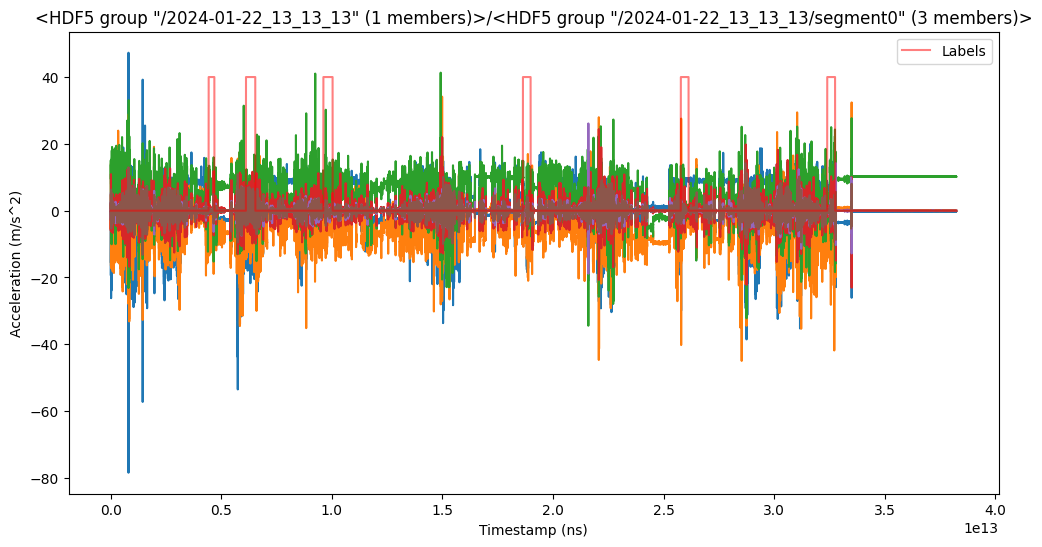

In [240]:
import h5py
import matplotlib.pyplot as plt

with h5py.File('tonmoy.hdf5', 'r') as h5f:
    print("Root metadata:", dict(h5f.attrs))
    recordings = list(h5f.keys())
    print("Recordings:", recordings)
    recording = h5f[recordings[0]]
    print("Recording metadata:", dict(recording.attrs))
    segments = list(recording.keys())
    print("Segments:", segments)
    segment = recording[segments[0]]
    print("Segment metadata:", dict(segment.attrs))

    for recording in recordings:
        recording = h5f[recording]
        segments = list(recording.keys())
        for segment in segments:
            segment = recording[segment]
            print(segment)
            # Plotting
            plt.figure(figsize=(12, 6))
            t,data = segment['timestamps'][:],segment['data'][:]
            plt.title(f"{recording}/{segment}")
            plt.plot(t,data)
            plt.plot(t,segment['labels'][:]*40, label='Labels', color='red', alpha=0.5)
            plt.xlabel('Timestamp (ns)')
            plt.ylabel('Acceleration (m/s^2)')
            plt.legend()
            plt.show()

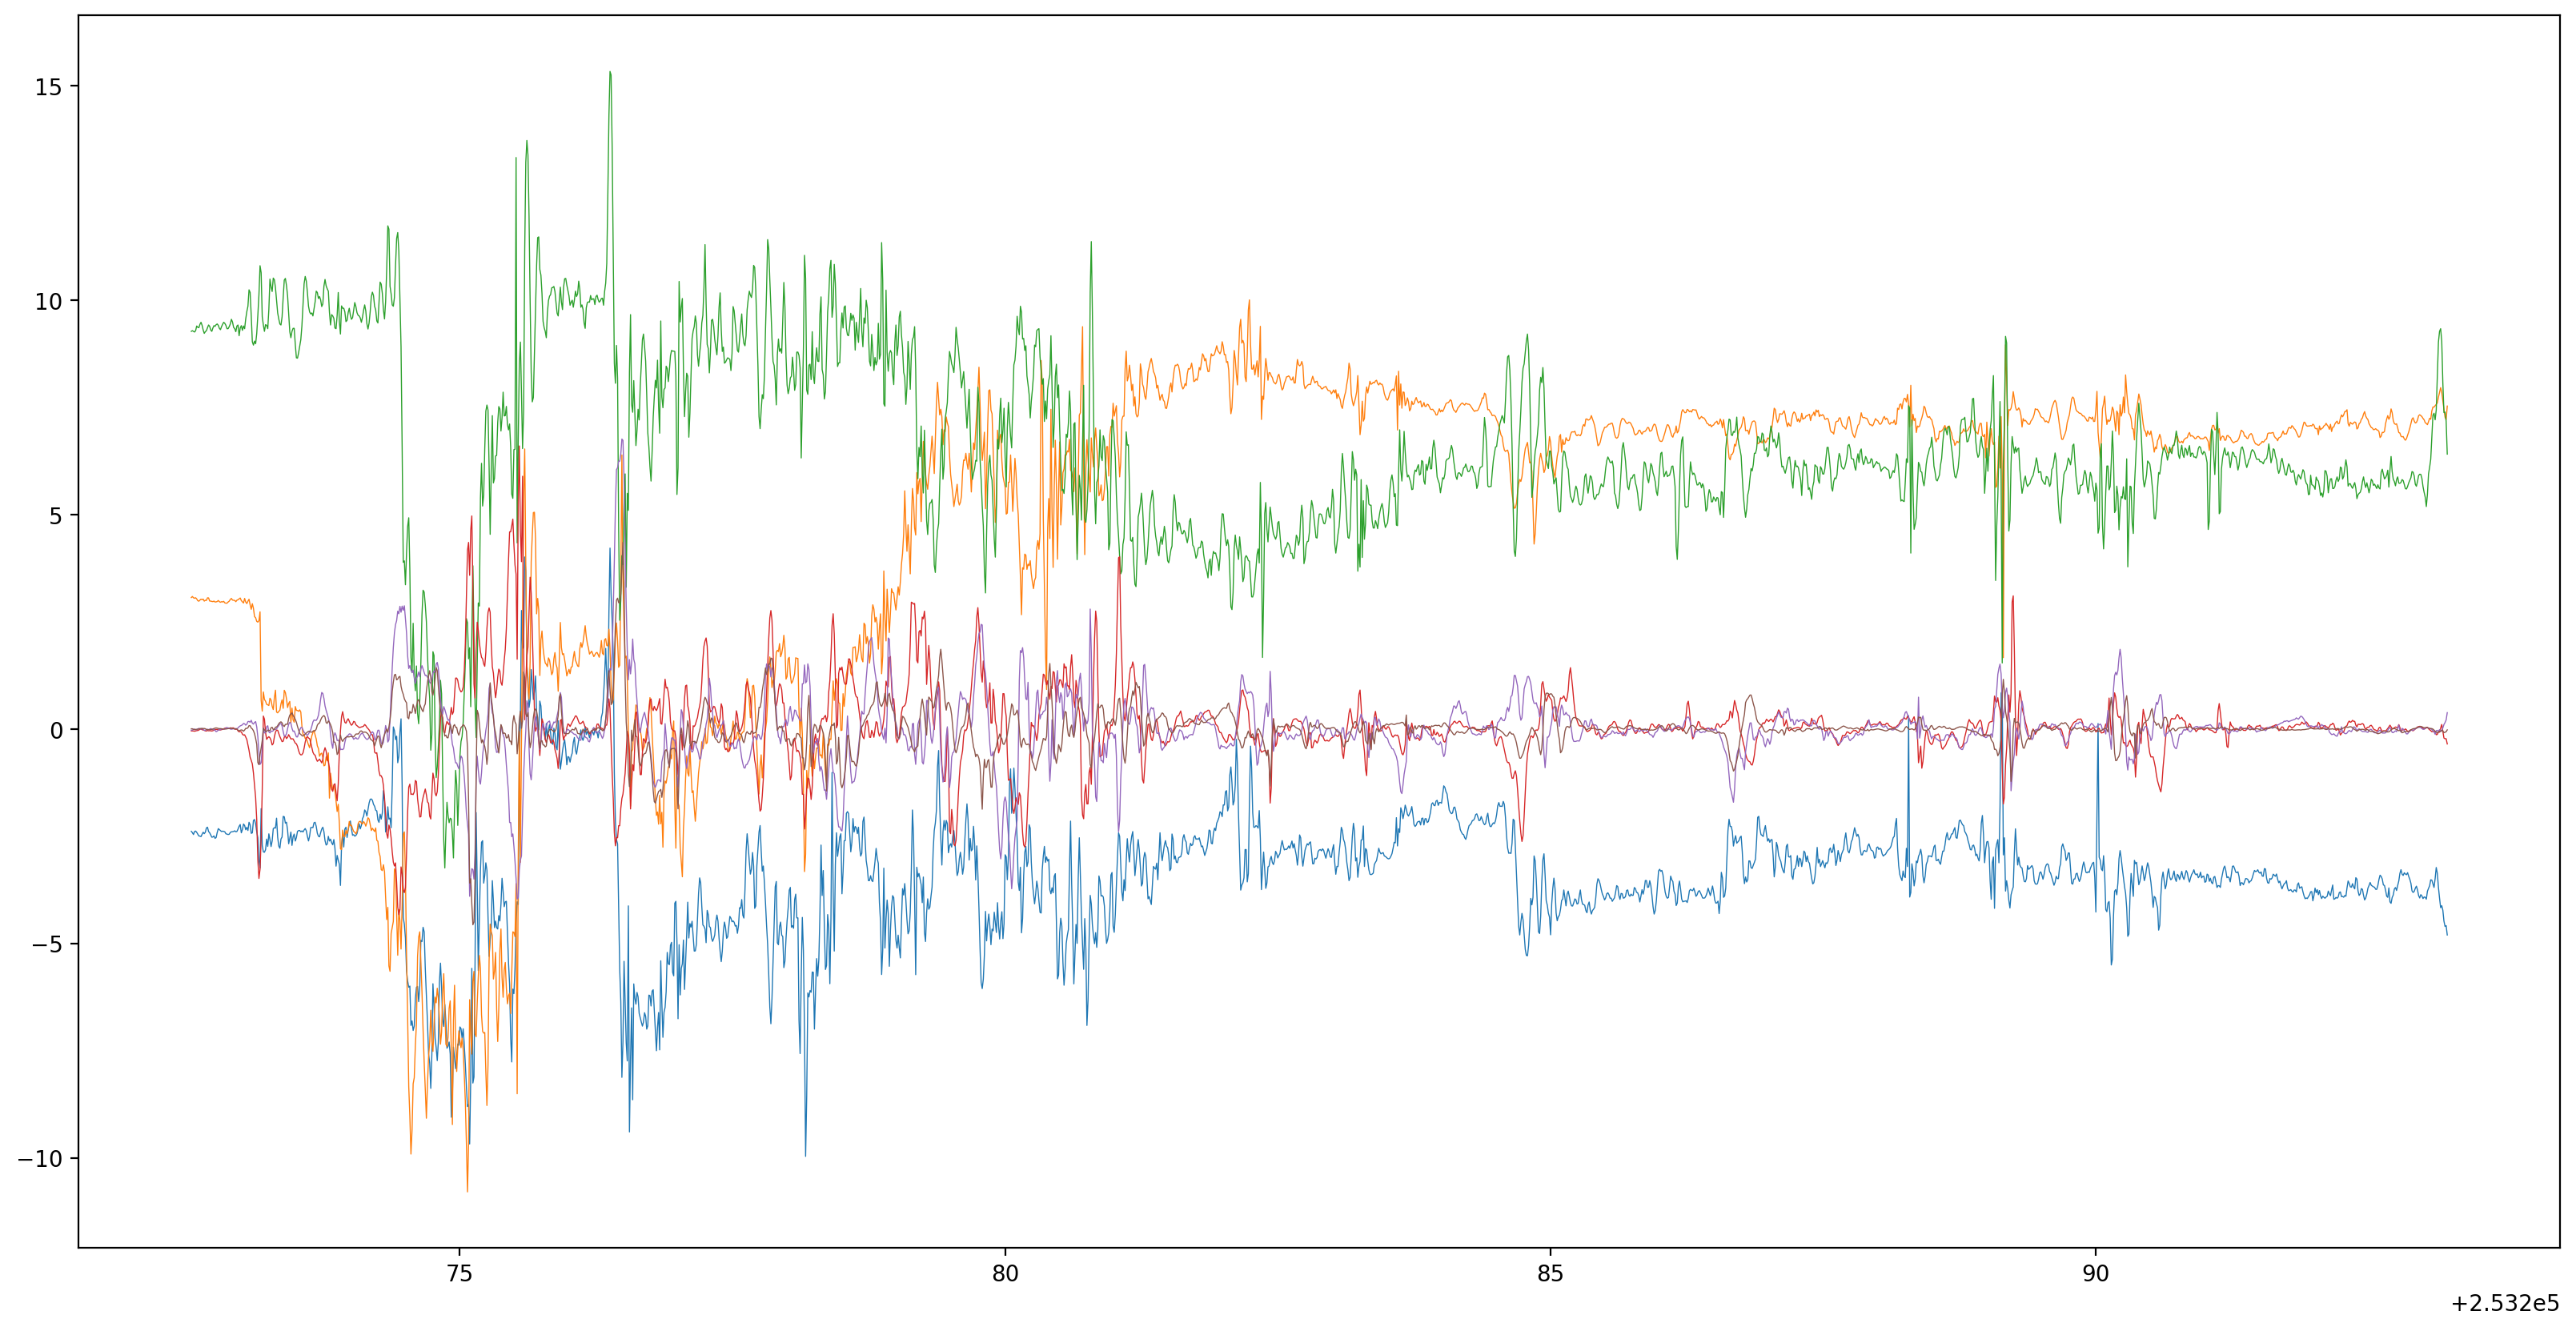

In [187]:
plt.figure(figsize=(20,10),dpi=200)
plt.plot(t*1e-9,data,linewidth=.5)

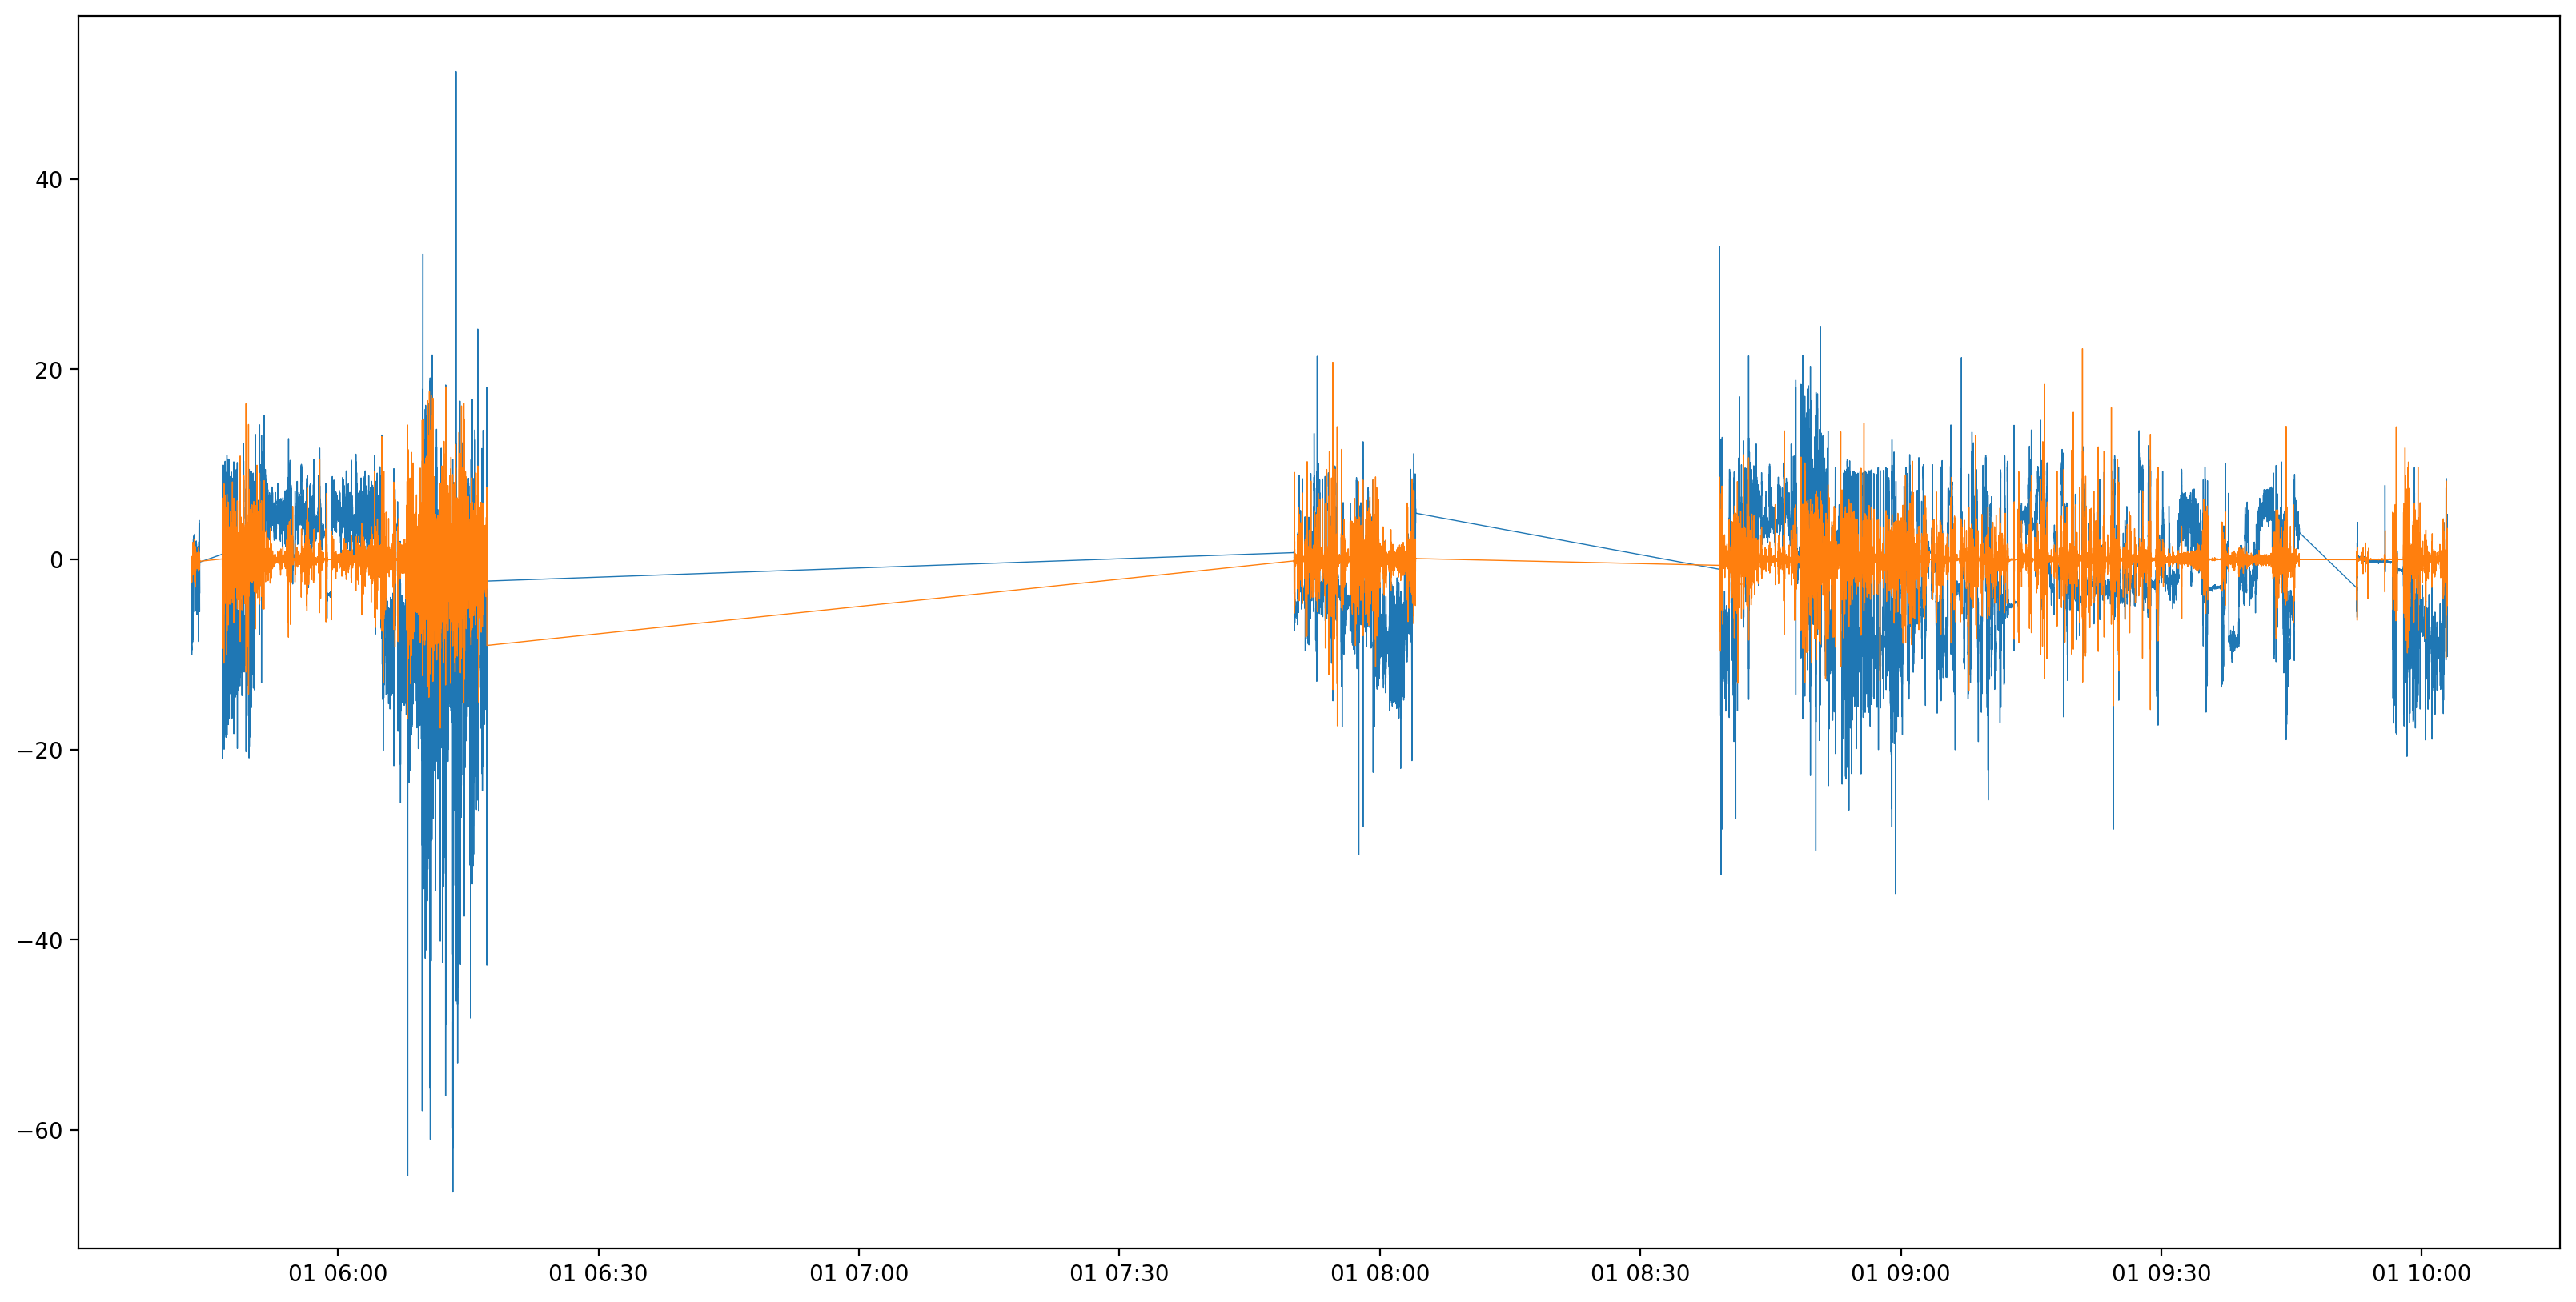

/opt/homebrew/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [124]:
import matplotlib.pyplot as plt

def plot_segment(segment):
    plt.figure(figsize=(20,10),dpi=200)
    plt.plot(segment['timestamp'],segment['x_x'],linewidth=.5)
    plt.plot(segment['timestamp'],segment['x_y'],linewidth=.5)
    plt.title('Segment')
    plt.xlabel('Timestamp')
    plt.ylabel('X-axis Acceleration')
    plt.show()

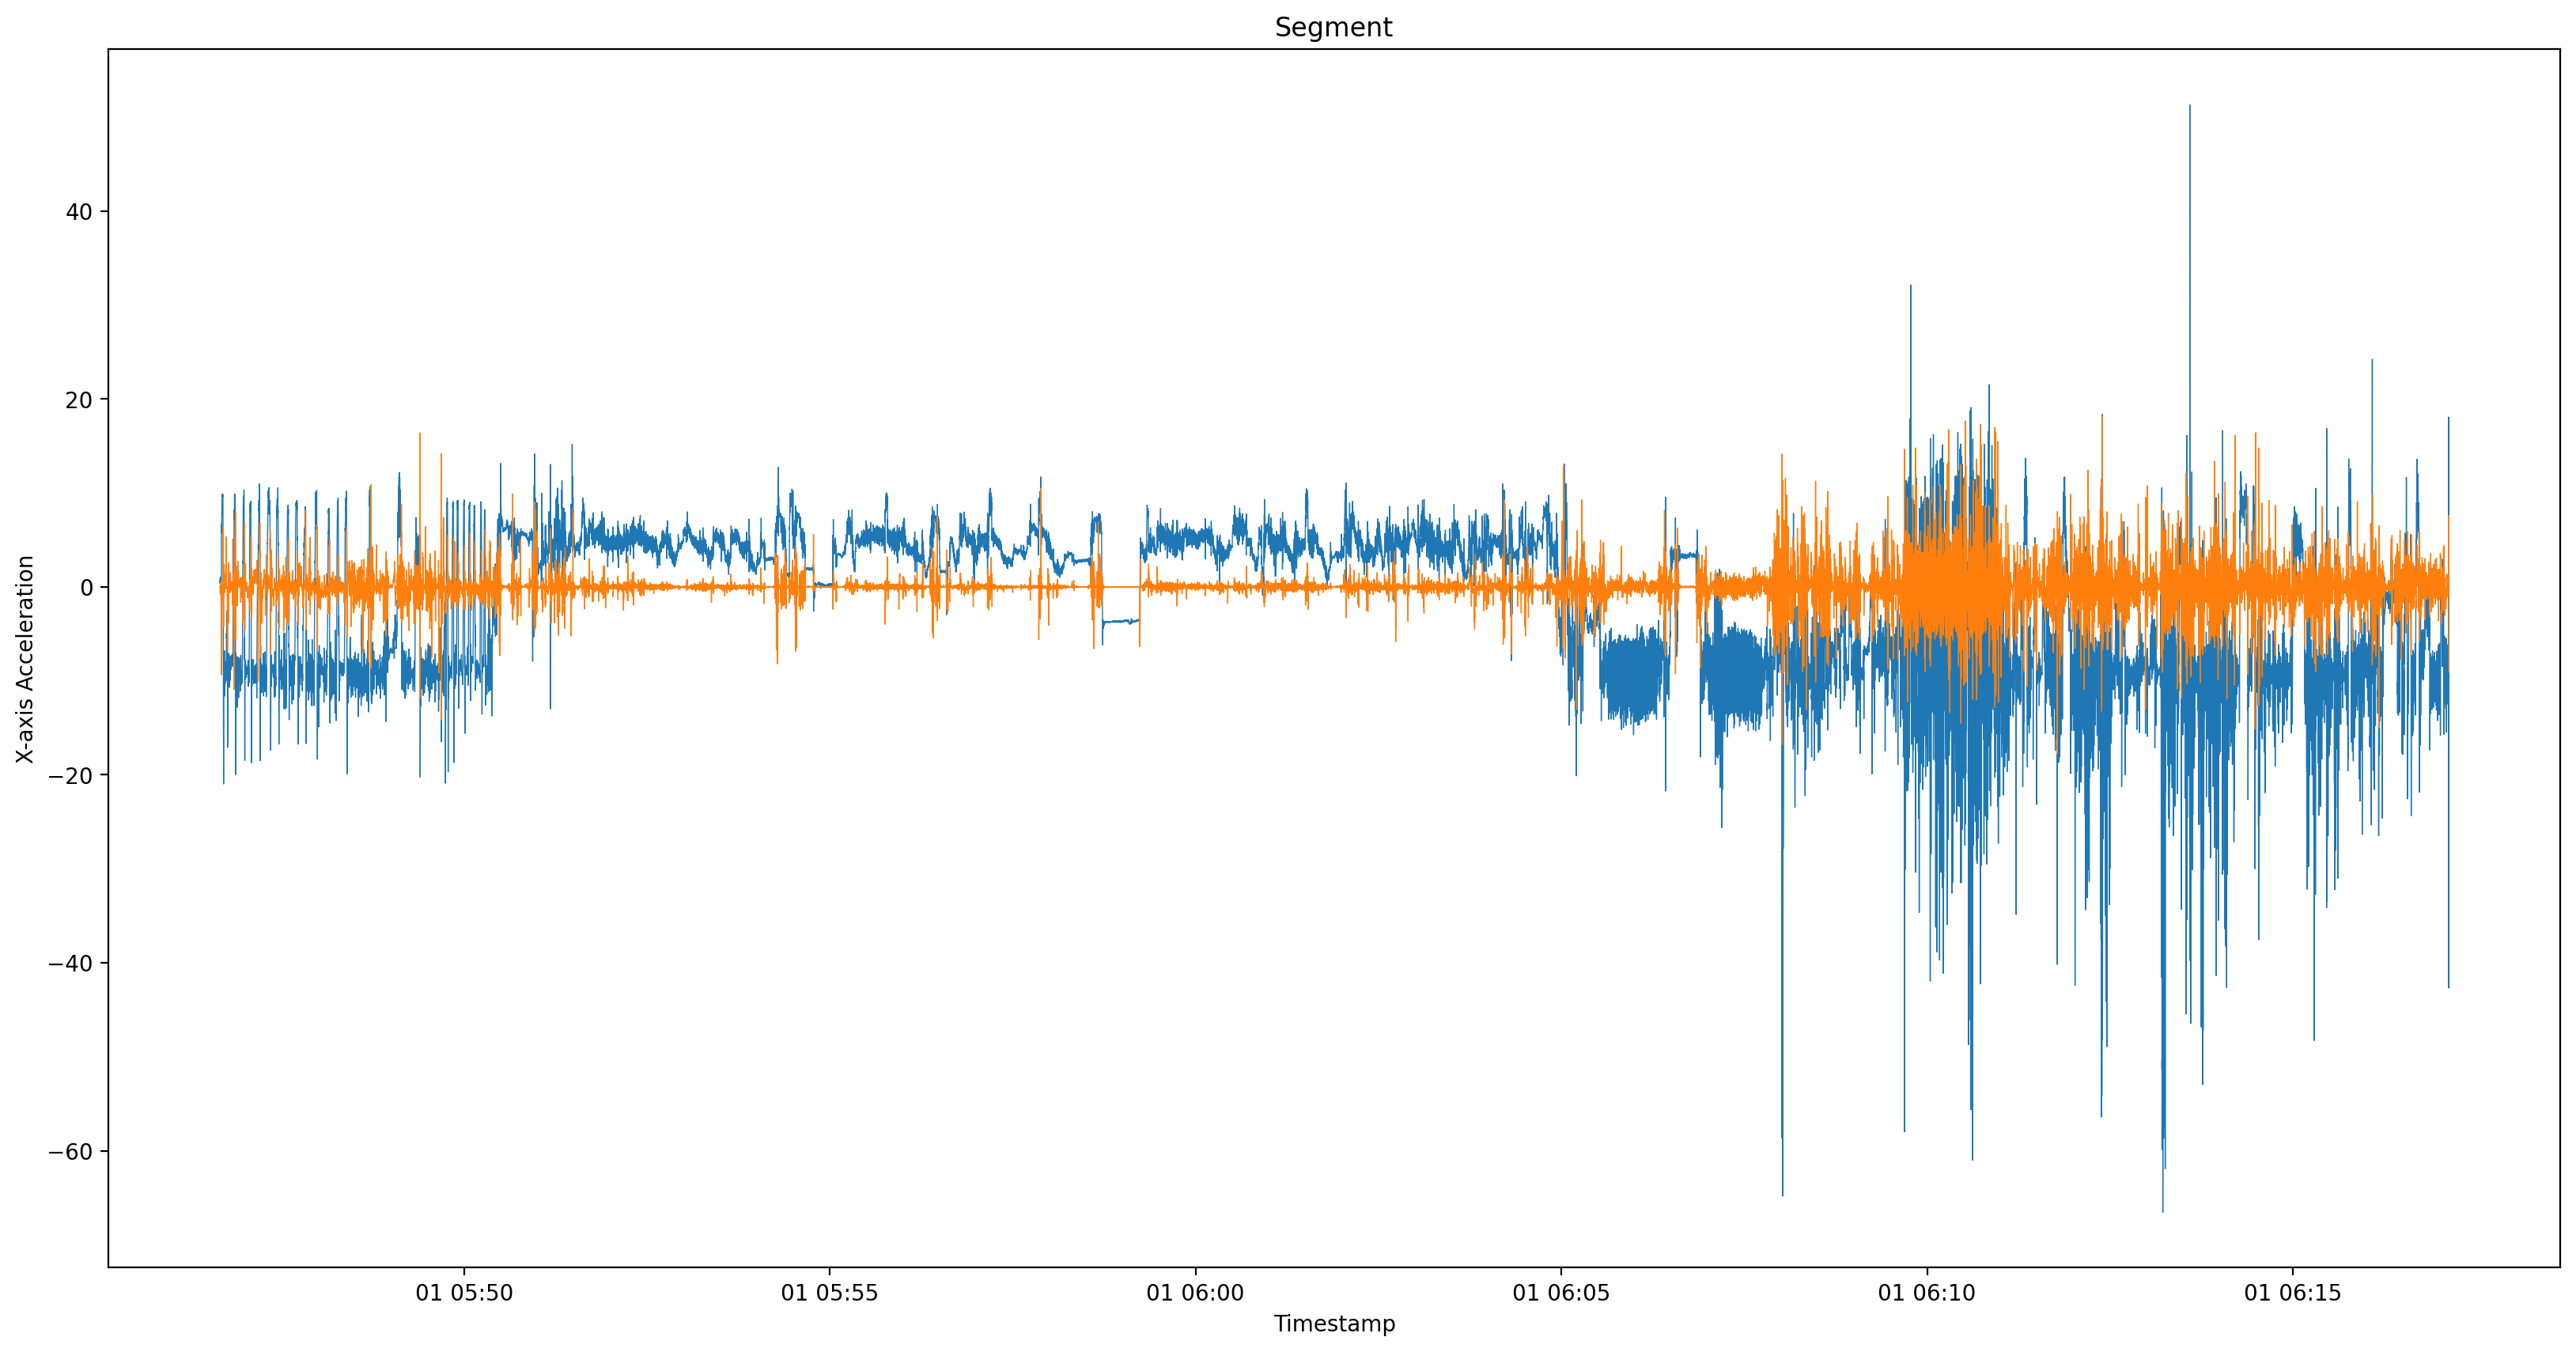

In [126]:
plot_segment(segments[1])